<a href="https://colab.research.google.com/github/venkyy23/chlorhexidine-survival-analysis/blob/main/Chlorhexidine_Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chlorhexidine Trial: Survival Analysis Using KM Curves, Log-Rank Test and Cox Model**

# 🌿 Section 1: Setup and Library Installation

In [6]:
!pip install lifelines


In [7]:
# Cell 2 — imports and file path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

# 📥 Section 2: Dataset Loading and Quick Overview

In [8]:
df = pd.read_excel("/content/Chlorhexidine Trials.xlsx")

print("Rows, Columns:", df.shape)
display(df.head(7))
print("\nColumn dtypes:\n", df.dtypes)


Rows, Columns: (106, 8)


,TrialArm,Age,Gender,Outcome of the current episode,event,APACHE II Score,TLC Day 1,time
0,1,49,Male,No VAP,0,11,11900,5
1,1,72,Male,No VAP,0,17,16800,6
2,1,72,Male,No VAP,0,16,23300,8
3,1,55,Female,No VAP,0,29,9500,10
4,1,20,Male,No VAP,0,18,7000,6
5,1,24,Male,No VAP,0,5,18600,10
6,1,36,Male,No VAP,0,19,14400,3



Column dtypes:
 TrialArm                           int64
Age                                int64
Gender                            object
Outcome of the current episode    object
event                              int64
APACHE II Score                    int64
TLC Day 1                          int64
time                               int64
dtype: object


# 🧹 Section 3: Data Cleaning, Encoding, and Preprocessing

In [9]:
# cleaning and encoding (rename, ensure numeric, create numeric encodings)
df = df.copy()

# 1) Rename for safe column names
rename_map = {
    'APACHE II Score': 'APACHEII',
    'TLC Day 1': 'TLC_D1',
}
df.rename(columns=rename_map, inplace=True)

# 2) Ensure time and event exist and are numeric
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['event'] = pd.to_numeric(df['event'], errors='coerce').astype('Int64')

# 3) Create numeric TrialArm (TrialArm_num)
if df['TrialArm'].dtype == object:
    try:
        df['TrialArm_num'] = pd.to_numeric(df['TrialArm'])
    except:
        df['TrialArm_num'] = df['TrialArm'].map({'Group 1':1, 'Group 2':2}).astype('Int64')
else:
    df['TrialArm_num'] = df['TrialArm'].astype('Int64')

# 4) Encode Gender into binary or dummies
if 'Gender' in df.columns:
    gender_unique = df['Gender'].dropna().unique().tolist()
    if set(gender_unique).issubset({'Male','Female'}):
        df['Gender_binary'] = df['Gender'].map({'Male':1,'Female':0}).astype('Int64')
    else:
        # create one-hot dummies (drop_first True to avoid collinearity)
        dummies = pd.get_dummies(df['Gender'], prefix='Gender', drop_first=True)
        df = pd.concat([df, dummies], axis=1)

# 5) Final dtype check for essential columns
essential = ['time','event','Age','APACHEII','TLC_D1','TrialArm_num']
missing_ess = [c for c in essential if c not in df.columns]
if missing_ess:
    raise ValueError(f"Missing required columns: {missing_ess}")

print("After encoding, example rows:")
display(df[ ['time','event','Age','APACHEII','TLC_D1','TrialArm_num'] ].head())
print("\nAny NA in time/event? ", df['time'].isna().any(), df['event'].isna().any())


After encoding, example rows:


,time,event,Age,APACHEII,TLC_D1,TrialArm_num
0,5,0,49,11,11900,1
1,6,0,72,17,16800,1
2,8,0,72,16,23300,1
3,10,0,55,29,9500,1
4,6,0,20,18,7000,1



Any NA in time/event?  False False


# 📊 Section 4: Baseline Summary Statistics

In [10]:
# baseline summary table for Results section
baseline_table = {
    "N": [len(df)],
    "Events (VAP)": [int(df['event'].sum())],
    "Age mean (SD)": [f"{df['Age'].mean():.1f} ({df['Age'].std():.1f})"],
    "APACHEII mean (SD)": [f"{df['APACHEII'].mean():.1f} ({df['APACHEII'].std():.1f})"],
    "TLC Day1 mean (SD)": [f"{df['TLC_D1'].mean():.0f} ({df['TLC_D1'].std():.0f})"],
    "Arm1 (n)": [int((df['TrialArm_num']==1).sum())],
    "Arm2 (n)": [int((df['TrialArm_num']==2).sum())],
    "Male (n)": [int((df['Gender']=='Male').sum()) if 'Gender' in df.columns else None],
    "Female (n)": [int((df['Gender']=='Female').sum()) if 'Gender' in df.columns else None],
    "Time mean (SD)": [f"{df['time'].mean():.1f} ({df['time'].std():.1f})"]
}
baseline_df = pd.DataFrame(baseline_table)
display(baseline_df.T.rename(columns={0:"Value"}))


,Value
N,106
Events (VAP),10
Age mean (SD),47.6 (17.3)
APACHEII mean (SD),16.9 (6.5)
TLC Day1 mean (SD),15216 (7270)
Arm1 (n),61
Arm2 (n),45
Male (n),93
Female (n),13
Time mean (SD),5.7 (2.4)


# 📈 Section 5: Kaplan–Meier Survival Curves (Overall)

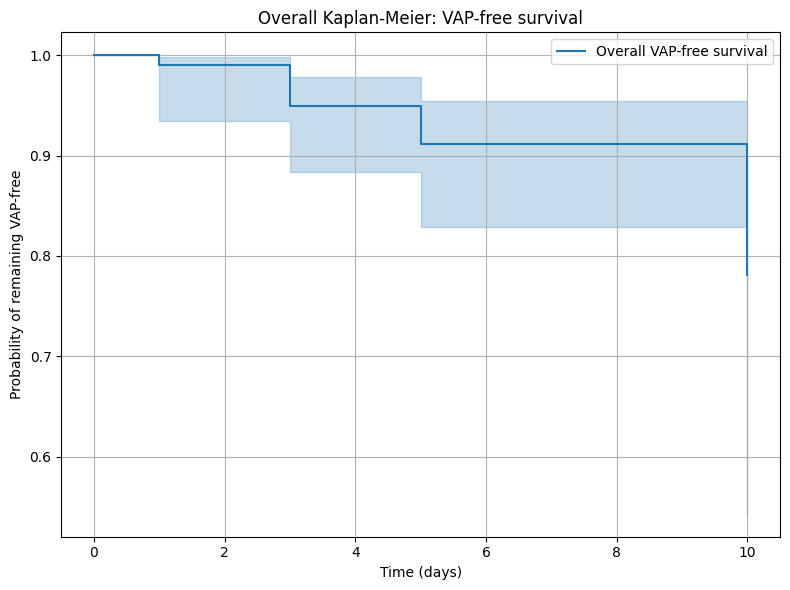

<Figure size 640x480 with 0 Axes>

In [11]:
# Overall Kaplan-Meier curve
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
kmf.fit(df['time'], df['event'], label='Overall VAP-free survival')
kmf.plot(ci_show=True)
plt.title("Overall Kaplan-Meier: VAP-free survival")
plt.xlabel("Time (days)")
plt.ylabel("Probability of remaining VAP-free")
plt.grid(True)
plt.tight_layout()
plt.show()
# saving it.
plt.savefig("km_overall.png", dpi=150)


# 🔍 Section 6: KM Curves by Treatment Group

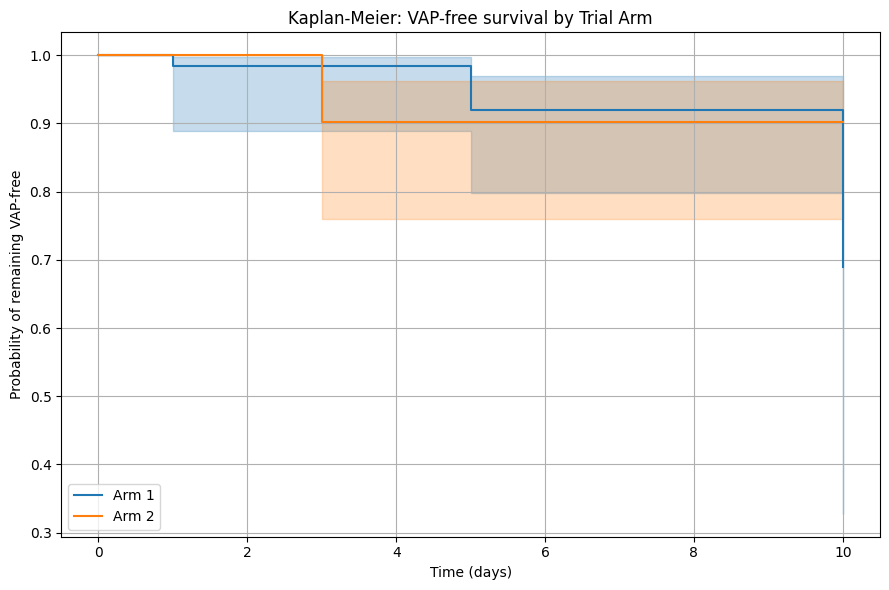

In [12]:
# KM stratified by TrialArm
arms = sorted(df['TrialArm_num'].unique())
km_objects = []

plt.figure(figsize=(9,6))
for a in arms:
    mask = df['TrialArm_num'] == a
    km = KaplanMeierFitter()
    km.fit(df.loc[mask,'time'], df.loc[mask,'event'], label=f"Arm {int(a)}")
    km.plot_survival_function(ci_show=True)
    km_objects.append(km)

plt.title("Kaplan-Meier: VAP-free survival by Trial Arm")
plt.xlabel("Time (days)")
plt.ylabel("Probability of remaining VAP-free")
plt.grid(True)
plt.tight_layout()

# 🧮 Section 7: Median Survival and Survival Probabilities

In [13]:
# median survival per arm and survival at day 5 (example)
print("Per-arm KM summary:")
for a in arms:
    mask = df['TrialArm_num'] == a
    km = KaplanMeierFitter().fit(df.loc[mask,'time'], df.loc[mask,'event'])
    median = km.median_survival_time_
    surv5 = km.survival_function_at_times(5).iloc[0] if 5 in km.survival_function_.index else np.nan
    print(f"Arm {int(a)}: N={mask.sum()}, Events={int(df.loc[mask,'event'].sum())}, Median={median}, Survival@Day5={surv5:.3f}")


Per-arm KM summary:
Arm 1: N=61, Events=6, Median=inf, Survival@Day5=0.919
Arm 2: N=45, Events=4, Median=inf, Survival@Day5=0.902


# ⚖️ Section 8: Log-Rank Test for Difference Between Arms

In [14]:
# log-rank test between Arm1 and Arm2
g1 = df[df['TrialArm_num']==1]
g2 = df[df['TrialArm_num']==2]

lr = logrank_test(g1['time'], g2['time'], event_observed_A=g1['event'], event_observed_B=g2['event'])
print("Log-rank test:")
lr.print_summary()
# Save P-value for table
print(f"P-value = {lr.p_value:.4f}")

Log-rank test:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.94      0.08

P-value = 0.9438


# 📦 Section 9: Preparing Data for Cox Regression

In [19]:
# prepare numeric cox_data (this is the dataframe we will use for fit & PH test)
model_cols = ['time','event','Age','APACHEII','TLC_D1','TrialArm_num']
# include gender binary/dummies
if 'Gender_binary' in df.columns:
    model_cols.append('Gender_binary')
else:
    gender_dummy_cols = [c for c in df.columns if c.startswith('Gender_')]
    model_cols += gender_dummy_cols

# ensure all exist
missing = [c for c in model_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing model cols: {missing}")

cox_data = df[model_cols].copy()

# coerce to numeric and impute median for predictors if necessary (time/event must not be NA)
for c in cox_data.columns:
    if c in ['time','event']:
        if cox_data[c].isna().any():
            raise ValueError(f"Column {c} contains missing values; fix before modeling.")
        continue
    cox_data[c] = pd.to_numeric(cox_data[c], errors='coerce')
    if cox_data[c].isna().any():
        med = cox_data[c].median()
        cox_data[c].fillna(med, inplace=True)
        print(f"Imputed {c} missing values with median={med}")

display(cox_data.describe().T)


,count,mean,std,min,25%,50%,75%,max
time,106.0,5.716981,2.377493,1.0,4.0,5.5,7.0,10.0
event,106.0,0.09434,0.293689,0.0,0.0,0.0,0.0,1.0
Age,106.0,47.59434,17.319286,18.0,32.0,50.0,62.0,75.0
APACHEII,106.0,16.933962,6.532365,4.0,12.0,17.0,21.0,36.0
TLC_D1,106.0,15216.037736,7269.677884,2100.0,11100.0,13100.0,18150.0,45000.0
TrialArm_num,106.0,1.424528,0.496619,1.0,1.0,1.0,2.0,2.0
Gender_binary,106.0,0.877358,0.329584,0.0,1.0,1.0,1.0,1.0


# 🔬 Section 10: Cox Proportional Hazards Model

In [16]:
# fit Cox model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time', event_col='event')
print("Cox PH summary:")
cph.print_summary()

# Save summary CSV (for tables in Word)
cph.summary.to_csv("cox_summary.csv")
print("Saved Cox summary to cox_summary.csv")


Cox PH summary:


<lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 10
   partial log-likelihood = -39.97
         time fit was run = 2025-11-23 08:42:10 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age           -0.01      0.99      0.02           -0.05            0.02                0.95                1.02
APACHEII      -0.04      0.97      0.05           -0.13            0.06                0.88                1.06
TLC_D1        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TrialArm_num  -0.03      0.97      0.71           -1.42            1.36                0.24                3.89
Gender_binary  0.64      1.90      1.13           -1.57            2.85                0.21               17.24

               cmp to     z    p  -log2(p)
covariate                                 
Age              0.00 -0.71 0.48      1.06
APACHEII         0.00 -0.73 0.47      1.10
TLC_D1           0.00 -0.58 0.56      0.83
TrialArm_num     0.00 -0.04 0.97      0.05
Gender_binary    0.00  0.57 0.57      0.81
---
Concordance = 0.59
Partial AIC = 89.94
log-likelihood ratio test = 2.01 on 5 df
-log2(p) of ll-ratio test = 0.24

Saved Cox summary to cox_summary.csv


# 📉 Section 11: Checking Proportional Hazards Assumption

Running proportional hazards checks (Schoenfeld residuals). Visuals will appear below.

   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.66996e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic    p  -log2(p)
APACHEII      km              0.01 0.91      0.14
              rank            0.04 0.85      0.23
Age           km              0.00 0.97      0.04
              rank            0.00 0.94      0.08
Gender_binary km              1.29 0.26      1.96
              rank            0.00 0.97      0.05
TLC_D1        km              0.61 0.44      1.20
              rank            0.50 0.48      1.06
TrialArm_num  km              3.72 0.05      4.21
              rank            2.90 0.09      3.50



1. Variable 'TrialArm_num' failed the non-proportional test: p-value is 0.0539.

   Advice: with so few unique values (only 2), you can include `strata=['TrialArm_num', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[[<Axes: xlabel='rank-transformed time\n(p=0.9445)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9694)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8503)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9057)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4799)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4350)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0886)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0539)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9653)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2566)'>]]

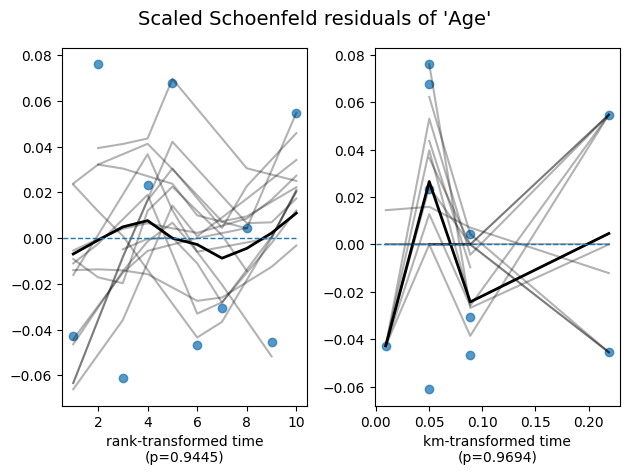

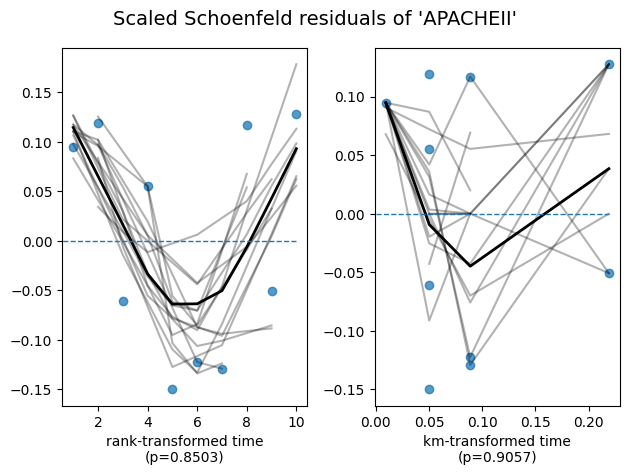

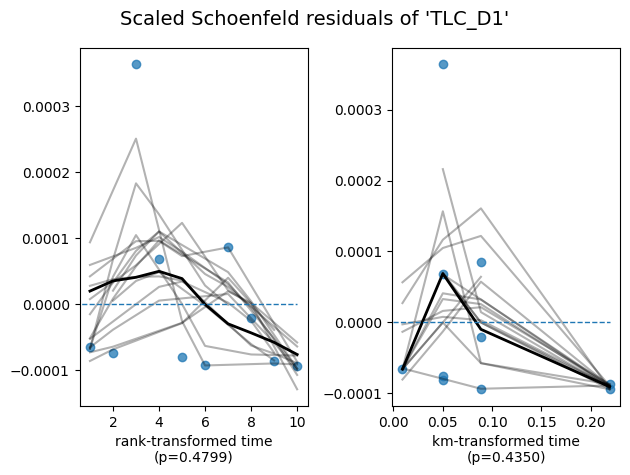

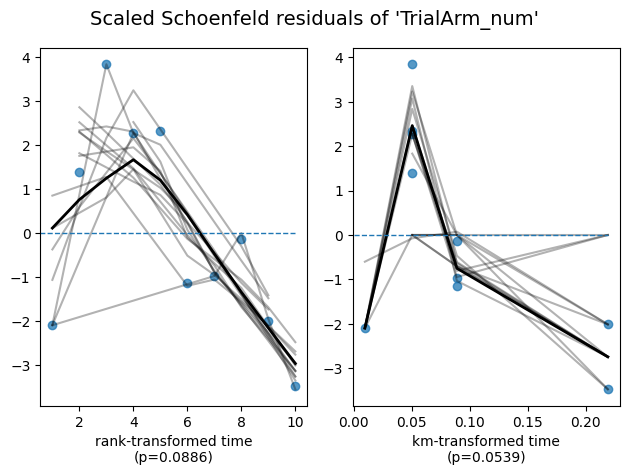

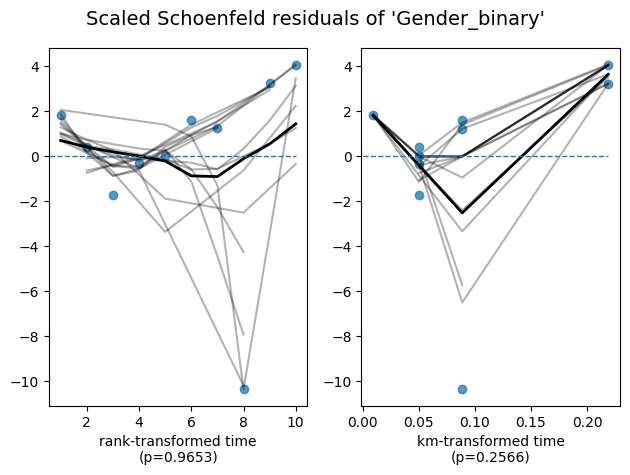

In [17]:
# proportional hazards check
# Use the same numeric dataframe used for fitting
print("Running proportional hazards checks (Schoenfeld residuals). Visuals will appear below.")
cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=True)


# 📑 Section 12: Final Tables for Inserting Into Report

In [18]:
# create tidy tables for copy-paste into Word

# KM table (per arm)
km_rows = []
for a in arms:
    mask = df['TrialArm_num']==a
    kmf = KaplanMeierFitter().fit(df.loc[mask,'time'], df.loc[mask,'event'])
    median = kmf.median_survival_time_
    surv5 = kmf.survival_function_at_times(5).iloc[0] if 5 in kmf.survival_function_.index else np.nan
    km_rows.append({"TrialArm": int(a), "N": int(mask.sum()), "Events": int(df.loc[mask,'event'].sum()),
                    "Median_time": median, "Survival_Day5": np.round(surv5,3)})
km_table = pd.DataFrame(km_rows)

# Cox table (HR, CI, p)
cox_table = cph.summary.reset_index()[['covariate','exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
cox_table.columns = ['Variable','HR','Lower95','Upper95','p_value']

display(km_table)
display(cox_table)

# Saving tables as CSV for insertion in Word
km_table.to_csv("km_table.csv", index=False)
cox_table.to_csv("cox_table.csv", index=False)
print("Saved tables: km_table.csv and cox_table.csv")


,TrialArm,N,Events,Median_time,Survival_Day5
0,1,61,6,inf,0.919
1,2,45,4,inf,0.902


,Variable,HR,Lower95,Upper95,p_value
0,Age,0.986361,0.949488,1.024666,0.479896
1,APACHEII,0.965321,0.877559,1.061861,0.467998
2,TLC_D1,0.999968,0.999861,1.000075,0.561931
3,TrialArm_num,0.971059,0.242103,3.894859,0.966946
4,Gender_binary,1.897335,0.208851,17.236556,0.569444


Saved tables: km_table.csv and cox_table.csv
